# 今天尝试一下其他的算法模型

- 注：前几天做为了用 snap 都是用 python2 做的，现在用换回到 python3 环境。

In [1]:
# 导入常用库
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time
from copy import deepcopy 
from tqdm import tqdm
% matplotlib inline

import networkx as nx
from networkx.algorithms import bipartite

## 1 随机游走算法

In [2]:
path = './ml-100k/'
# 读入数据
names = ['user_id', 'item_id', 'rating', 'timestamp']
df_train = pd.read_csv(path+'u1.base', sep='\t', names=names)
df_test = pd.read_csv(path+'u1.test', sep='\t', names=names)
print(len(df_train))
print(len(df_test))

80000
20000


In [3]:
def preprocess(data):
    data['u_user_id'] = data['user_id'].map(lambda x: 'u'+str(x))
    data['i_item_id'] = data['item_id'].map(lambda x: 'i'+str(x))
    data['edges'] = data.apply(lambda x: (x['u_user_id'], x['i_item_id']), axis = 1)
    # 获得 user 节点，以及 item 节点
    user_ids = data.u_user_id.unique().tolist()
    item_ids = data.i_item_id.unique().tolist()
    edges = data.edges.unique().tolist()
    print('user_ids : {}'.format(len(user_ids)))
    print('item_ids : {}'.format(len(item_ids)))
    
    B = nx.Graph()
    B.add_nodes_from(user_ids, bipartite=0)
    B.add_nodes_from(item_ids, bipartite=1)
    B.add_edges_from(edges)
    print(nx.is_connected(B))
    return B

参考 Pixie: A System for Recommending 3+ Billion Items to 200+ Million Users in Real-Time 的 3.1 节

In [4]:
def random_walk(G, alpha, N, root):
    '''
    G：图的结构，包含节点和边
    alpha:决定漫步的长度
    N:漫步的总的步数
    root:开始的节点
    '''
    rank = {x:0 for x in G.nodes}
    totSteps = 0
    while totSteps <= N:
        currPin = root
        currSteps = np.random.randint(0, alpha)
        for i in range(currSteps):
            #随机选择与 root 相连的邻接点
            nbs_1 = list(G.neighbors(currPin))
            currBoard = nbs_1[np.random.randint(0, len(nbs_1))]
            nbs_2 = list(G.neighbors(currBoard))
            currPin = nbs_2[np.random.randint(0, len(nbs_2))]
            nbs_3 = list(G.neighbors(currPin))
            currBoard = nbs_3[np.random.randint(0, len(nbs_3))]
            rank[currBoard] += 1
            
        totSteps += currSteps
    return rank

In [5]:
B_train = preprocess(df_train)
B_test = preprocess(df_test)

user_ids : 943
item_ids : 1650
True
user_ids : 459
item_ids : 1410
True


In [6]:
'''
user = 'u1'
item_ids = df_test[df_test.u_user_id == user].i_item_id.unique().tolist()
# 注意，每次传入的B_train都是新的，否则容易把 test 的边引入进来
# 例如， user1 和 user2 都对 test 的 item1 相连，如果测试 user1 时，添加进了
# （user2，item1）边，则在测试 user2 时，此边就变成已存在的，无法删除
B_train.add_nodes_from(item_ids, bipartite=1)
edges = df_test[(df_test.i_item_id.isin(item_ids) & (df_test.u_user_id != user))].edges.unique().tolist()
B_train.add_edges_from(edges)

rank = random_walk(B_train, 20, 1000, 'u1')
max([rank[key] for key in rank if 'u' not in key])
'''

"\nuser = 'u1'\nitem_ids = df_test[df_test.u_user_id == user].i_item_id.unique().tolist()\n# 注意，每次传入的B_train都是新的，否则容易把 test 的边引入进来\n# 例如， user1 和 user2 都对 test 的 item1 相连，如果测试 user1 时，添加进了\n# （user2，item1）边，则在测试 user2 时，此边就变成已存在的，无法删除\nB_train.add_nodes_from(item_ids, bipartite=1)\nedges = df_test[(df_test.i_item_id.isin(item_ids) & (df_test.u_user_id != user))].edges.unique().tolist()\nB_train.add_edges_from(edges)\n\nrank = random_walk(B_train, 20, 1000, 'u1')\nmax([rank[key] for key in rank if 'u' not in key])\n"

In [7]:
def predict(data, rank, user, top_k):
    connect_item = [item_id for item_id in list(set(data[data['u_user_id'] == user]['i_item_id']))]
    recommend_item = [(key, rank[key]) for key in rank if key not in connect_item and 'u' not in key]
    top_k_item = sorted(recommend_item, key=lambda x: x[1], reverse=True)[:top_k]
    return top_k_item

In [8]:
def precision(test, user, top_k_item):
    r_all = len(top_k_item)
    if r_all != 0:
        recom_list = [int(key[0][1:]) for key in top_k_item]
        data = test[test.u_user_id==user]
        r = len(data[(data.item_id.isin(recom_list))].item_id.unique())
        p = r*1.0/r_all
        return p
    else:
        return -2

def recall(test, user ,top_k_item):
    tu = test[test.u_user_id == user]['item_id'].nunique()
    if tu != 0:
        recom_list = [int(key[0][1:]) for key in top_k_item]
        data = test[test.u_user_id==user]
        r = len(data[(data.item_id.isin(recom_list))].item_id.unique())
        rec = r*1.0/tu
        return rec
    else:
        return -2

In [9]:
# 获取 user 集合
user_list = df_train.u_user_id.unique().tolist()
rec = []
pre = []
G = deepcopy(B_train)
begin_time = time.time()
for user in tqdm(user_list):
    item_ids = df_test[df_test.u_user_id == user].i_item_id.unique().tolist()
    # 注意，每次传入的B_train都是新的，否则容易把 test 的边引入进来
    # 例如， user1 和 user2 都对 test 的 item1 相连，如果测试 user1 时，添加进了
    # （user2，item1）边，则在测试 user2 时，此边就变成已存在的，无法删除
    B_train = deepcopy(G)
    B_train.add_nodes_from(item_ids, bipartite=1)
    edges = df_test[(df_test.i_item_id.isin(item_ids) & (df_test.u_user_id != user))].edges.unique().tolist()
    B_train.add_edges_from(edges)
    if(nx.is_connected(B_train)):
        #rank = train(B_train, 0.6, user)
        rank = random_walk(G, 20, 10000, user)
        # top_k 的值取 train 里面相连的 1/4
        top_k = int(len(list(B_train.neighbors(user)))/4)
        top_k_item = predict(df_train, rank, user, top_k)
        p = precision(df_test, user, top_k_item) 
        r = recall(df_test, user, top_k_item)
        rec.append(r)
        pre.append(p)
    else:
        rec.append(-1)
        pre.append(-1)
        
        
end_time = time.time()
print("用时 ： {}".format(end_time-begin_time))

100%|██████████| 943/943 [12:45<00:00,  1.23it/s]

用时 ： 765.7359750270844


In [10]:
result = pd.DataFrame({'u_user_id':user_list, 'pre':pre, 'rec':rec})
result.to_csv("result_random_walk.csv", index=None)

In [11]:
result.head()

,pre,rec,u_user_id
0,0.636364,0.153285,u1
1,0.200000,0.090909,u2
2,0.285714,0.076923,u3
3,0.666667,0.200000,u4
4,0.272727,0.071429,u5


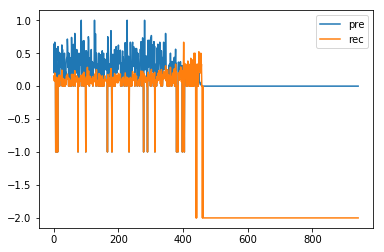

In [12]:
result[['pre','rec']].plot()

- 从绘图的结果来看，id 靠前的用户，精确率一般大于召回率。这是由于我们推荐的TOP K中，K值过小（一般是正常的1/4），如果提高 K 值，则会提高召回率，但是会降低精确率。
- 对比 day_3 的数据发现，整体的精确率和召回率比 PersonalRank 低，分析原因在于随机游走不确定性变大导致。 